In [1]:
import tensorflow as tf
from tqdm import tqdm
from utils import *
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Parameters
num_nodes = 500
num_blocks = 4

In [3]:
trainer = get_trainer()
x_feed,y_feed = trainer.next_batch()

In [4]:
def dense_layer(x,num_nodes,activation='relu',name_suffix='',bias_init_val=1):
    """
    Dense fully connected layer
    y = activation(xW+b)
    
    Inputs
    ------------------
    x : input tensor
    
    num_nodes : number of nodes in the layer
    
    acitvation (optional: activation function to use 
         one of ['relu','sigmoid',None]
         default is 'relu'
    
    name_suffix (optional) : the suffix to append to variable names
    
    bias_init_val (optional) : the initial value of the bias

    
    Outputs
    ---------------------
    y : the output tensor
    """
    input_shape = x.get_shape()
    W=tf.get_variable('W'+name_suffix,initializer=tf.random_normal(stddev=.01,shape=[int(input_shape[-1]),num_nodes]))
    b=tf.get_variable('b'+name_suffix,initializer=tf.constant(bias_init_val,shape = [num_nodes],dtype=tf.float32))
    
    logits = tf.matmul(x,W)+b
    
    if activation == None:
        y = logits
    elif activation == 'relu':
        y = tf.nn.relu(logits)
    elif activation == 'sigmoid':
        y = tf.nn.sigmoid(logits)
    else:
        raise ValueError("Enter a valid activation function")
    
    return y

In [12]:
def highway_block(x,layer,num_nodes=784):
    """
    Highway Network block
    
    H(x)*T(x)+(1-T(x))*x
    
    Input:
    x : tensor input
    
    layer : layer number for the highway block
    
    Output:
    r : last layer in the highway block
    """
    input_shape = x.get_shape()
    with tf.variable_scope('highway_%d'%layer):
        H = dense_layer(x,name_suffix='_h',num_nodes=num_nodes,activation='relu')
        T = dense_layer(x,name_suffix='_t',num_nodes=num_nodes,activation='sigmoid',bias_init_val=-1)
    return H*T + (1.-T)*x

In [13]:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32,shape=[None,x_feed.shape[-1]])
    y = tf.placeholder(tf.float32,shape=[None,y_feed.shape[-1]])
    
    
    hn = dense_layer(x,num_nodes = num_nodes,activation=None,name_suffix='pjct')
    for i in range(num_blocks):
        hn = highway_block(hn,layer=i,num_nodes=num_nodes)
    fc = dense_layer(hn,num_nodes=10,activation=None,name_suffix='fc')
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc,labels=y))
    
    opt = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)
    
    pred = tf.nn.softmax(fc)
    
    init = tf.global_variables_initializer()

In [14]:
sess = tf.Session(graph=g)
sess.run(init)
num_steps = 100
losses = []
for i in tqdm(range(num_steps)):
    x_feed,y_feed = trainer.next_batch()
    fd = {x : x_feed, y : y_feed}
    l , _ = sess.run([loss,opt],feed_dict = fd)
    losses.append(l)

100%|██████████| 100/100 [00:01<00:00, 73.68it/s]


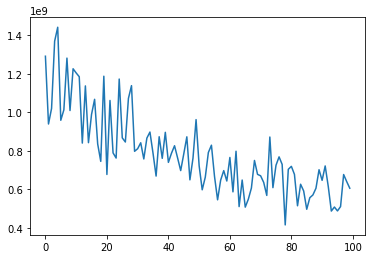

In [8]:
plt.plot(losses)

In [9]:
x_feed,y_feed = get_train()
fd = {x : x_feed, y : y_feed}
y_hat = sess.run(pred,feed_dict=fd)
accuracy(y_feed,y_hat)

0.23160416666666667

In [10]:
x_feed,y_feed = get_validation()
fd = {x : x_feed, y : y_feed}
y_hat = sess.run(pred,feed_dict=fd)
accuracy(y_feed,y_hat)

0.23058333333333333

In [11]:
x_feed,y_feed = get_test()
fd = {x : x_feed, y : y_feed}
y_hat = sess.run(pred,feed_dict=fd)
accuracy(y_feed,y_hat)

0.24429999999999999